In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns 
import os

# =========================================================
# ⚙️ KONFIGURASI
# =========================================================
FOLDER_DATA = "/work/open_meteo_climate"
NAMA_FILE = "kebumen_75tahun_lengkap.csv" 
PATH_FILE = os.path.join(FOLDER_DATA, NAMA_FILE)

In [4]:
# =========================================================
# 1. LOAD DATA
# =========================================================
def load_data(filepath):
    if not os.path.exists(filepath):
        print(f"❌ File tidak ditemukan: {filepath}")
        return None
    try:
        df = pd.read_csv(filepath, index_col='date')
        df.index = pd.to_datetime(df.index, utc=True, errors='coerce')
        df.index = df.index.tz_convert('Asia/Jakarta')
        df.index = df.index.tz_localize(None)
        df = df.sort_index()
        return df
    except Exception as e:
        print(f"❌ Error: {e}")
        return None

# =========================================================
# 2. FUNGSI ANALISIS DETAIL (DISIMPLIFIKASI)
# =========================================================
def analisis_detail(df, target_waktu):
    print(f"\n🔎 ANALISIS DETAIL PERIODE: {target_waktu}")
    print("="*50)
    
    try:
        subset = df.loc[target_waktu]
        if subset.empty:
            print("⚠️ Data tidak ditemukan.")
            return

        # --- A. ANALISIS SUHU ---
        print("🌡️ STATISTIK SUHU")
        
        # Hitung Rata-rata
        avg_temp = subset['temperature'].mean()
        
        # Cari Max & Min
        max_temp = subset['temperature'].max()
        max_temp_date = subset['temperature'].idxmax()
        min_temp = subset['temperature'].min()
        min_temp_date = subset['temperature'].idxmin()
        
        print(f"      Rata-rata Suhu: {avg_temp:.2f}°C") # <--- TAMBAHAN
        print(f"   🔥 Paling Panas  : {max_temp:.2f}°C (pada {max_temp_date})")
        print(f"   ❄️ Paling Dingin : {min_temp:.2f}°C (pada {min_temp_date})")
        print("-" * 30)

        # --- B. ANALISIS HUJAN (KATEGORI BARU) ---
        print("🌧️ STATISTIK HUJAN")
        
        # Agregasi Harian
        harian = subset['rain_mm'].resample('D').sum()
        
        # 1. Total & Max
        total_hujan = harian.sum()
        max_hujan_sehari = harian.max()
        tgl_max_hujan = harian.idxmax().strftime('%Y-%m-%d')
        
        print(f"🌧️Total Curah Hujan : {total_hujan:.2f} mm")
        print(f"🌧️Hujan Terlebat   : {max_hujan_sehari:.2f} mm (Tgl {tgl_max_hujan})")
        
        # 2. Kategori Sederhana (Basah vs Kering)
        # Hari Basah: > 10 mm
        hari_basah = harian[harian > 10]
        jml_hari_basah = len(hari_basah)
        
        # Hari Kering: <= 10 mm (Termasuk 0 mm dan gerimis)
        hari_kering = harian[harian <= 10]
        jml_hari_kering = len(hari_kering)
        
        print(f"☔ Hari Basah (>10mm)  : {jml_hari_basah} hari")
        print(f"☀️ Hari Kering (<=10mm): {jml_hari_kering} hari")
        
        print("="*50)

    except KeyError:
        print(f"❌ Format waktu salah. Gunakan 'YYYY' atau 'YYYY-MM'.")
    except Exception as e:
        print(f"⚠️ Error analisis: {e}")

# =========================================================
# 3. FUNGSI PLOTTING
# =========================================================
def plot_periode_tertentu(df, target_waktu):
    print(f"\n🎨 Menggambar grafik untuk periode: {target_waktu}...")
    try:
        subset = df.loc[target_waktu]
        if subset.empty: return

        fig, ax1 = plt.subplots(figsize=(12, 6))
        
        # Plot Suhu
        ax1.plot(subset.index, subset['temperature'], 
                 color='darkorange', marker='', linestyle='-', linewidth=1.5, label='Suhu (°C)')
        ax1.set_ylabel('Suhu (°C)', color='darkorange', fontweight='bold')
        ax1.tick_params(axis='y', labelcolor='darkorange')
        ax1.grid(True, linestyle='--', alpha=0.5)
        
        # Plot Hujan
        ax2 = ax1.twinx()
        width = 0.04 if len(str(target_waktu)) > 7 else 0.5 
        ax2.bar(subset.index, subset['rain_mm'], 
                color='dodgerblue', alpha=0.4, width=width, label='Hujan (mm)')
        ax2.set_ylabel('Hujan (mm)', color='dodgerblue', fontweight='bold')
        ax2.tick_params(axis='y', labelcolor='dodgerblue')
        
        # Format Sumbu X
        if len(str(target_waktu)) > 7:
            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
            ax1.set_xlabel('Jam (WIB)')
            judul = f"Cuaca Detail Tanggal: {target_waktu}"
        elif len(str(target_waktu)) == 7:
            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
            ax1.set_xlabel('Tanggal')
            judul = f"Tren Cuaca Bulan: {target_waktu}"
        else:
            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
            ax1.set_xlabel('Bulan')
            judul = f"Tren Cuaca Tahun: {target_waktu}"

        plt.title(judul, fontweight='bold', fontsize=14)
        
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"⚠️ Terjadi error saat plotting: {e}")

In [7]:
# =========================================================
# 4. FUNGSI PLOTTING KHUSUS HARIAN (DETAIL JAM)
# =========================================================
def plot_harian_detail(df, target_tanggal):
    """
    Plotting khusus untuk satu hari penuh (00:00 - 23:00).
    Format target_tanggal: 'YYYY-MM-DD' (Contoh: '2022-11-05')
    """
    print(f"\n🎨 Menggambar grafik detail harian: {target_tanggal}...")
    
    try:
        # Slicing data (Partial String Indexing)
        subset = df.loc[target_tanggal]
        
        if subset.empty:
            print(f"⚠️ Data kosong untuk tanggal {target_tanggal}")
            return

        fig, ax1 = plt.subplots(figsize=(12, 6))
        
        # --- 1. PLOT SUHU (GARIS) ---
        ax1.plot(subset.index, subset['temperature'], 
                 color='#FF4500', linewidth=2, marker='o', markersize=4, label='Suhu (°C)')
        ax1.set_ylabel('Suhu (°C)', color='#FF4500', fontweight='bold')
        ax1.tick_params(axis='y', labelcolor='#FF4500')
        ax1.grid(True, linestyle='--', alpha=0.3)
        
        # Tandai Suhu Maksimum dengan Titik Besar & Teks
        max_temp = subset['temperature'].max()
        max_temp_time = subset['temperature'].idxmax()
        ax1.annotate(f'Max: {max_temp}°C', 
                     xy=(max_temp_time, max_temp), 
                     xytext=(0, 10), textcoords='offset points',
                     ha='center', color='red', fontweight='bold')

        # --- 2. PLOT HUJAN (BAR) ---
        ax2 = ax1.twinx()
        ax2.bar(subset.index, subset['rain_mm'], 
                color='#00BFFF', alpha=0.5, width=0.03, label='Hujan (mm)')
        ax2.set_ylabel('Hujan (mm)', color='#00BFFF', fontweight='bold')
        ax2.tick_params(axis='y', labelcolor='#00BFFF')
        
        # Atur batas atas hujan biar barnya tidak menutupi grafik suhu
        max_rain = subset['rain_mm'].max()
        top_limit = max_rain * 2 if max_rain > 0 else 10
        ax2.set_ylim(0, top_limit)

        # --- 3. FORMAT SUMBU X (JAM) ---
        # Format label jam: 00:00, 03:00, dst
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax1.xaxis.set_major_locator(mdates.HourLocator(interval=3)) # Interval tiap 3 jam
        ax1.set_xlabel('Waktu (WIB)', fontweight='bold')
        
        # Judul
        plt.title(f"Dinamika Cuaca Harian: {target_tanggal}", fontsize=14, fontweight='bold', pad=15)
        
        # Legend Gabungan
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
        
        plt.tight_layout()
        plt.show()

    except KeyError:
        print("❌ Format tanggal salah. Gunakan 'YYYY-MM-DD'.")
    except Exception as e:
        print(f"⚠️ Error plotting harian: {e}")


🔎 ANALISIS DETAIL PERIODE: 2025-10
🌡️ STATISTIK SUHU
      Rata-rata Suhu: 25.92°C
   🔥 Paling Panas  : 30.39°C (pada 2025-10-14 12:00:00)
   ❄️ Paling Dingin : 22.44°C (pada 2025-10-08 03:00:00)
------------------------------
🌧️ STATISTIK HUJAN
🌧️Total Curah Hujan : 316.10 mm
🌧️Hujan Terlebat   : 39.20 mm (Tgl 2025-10-28)
☔ Hari Basah (>10mm)  : 8 hari
☀️ Hari Kering (<=10mm): 23 hari

🎨 Menggambar grafik untuk periode: 2025-10...


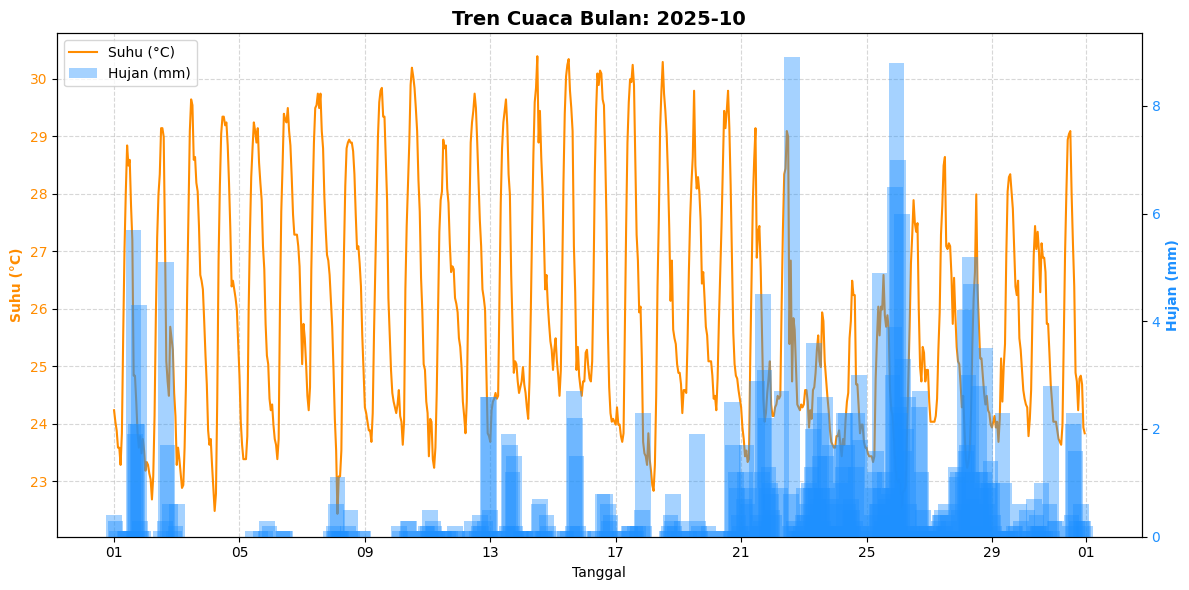

In [10]:
# =========================================================
# EKSEKUSI UTAMA
# =========================================================
if __name__ == "__main__":
    df_cuaca = load_data(PATH_FILE)
    
    if df_cuaca is not None:
        # Contoh Analisis Bulan Oktober 2022 (Bulan Basah)
        TARGET = "2025-10"
        
        # 1. Tampilkan Angka Statistik
        analisis_detail(df_cuaca, TARGET)
        
        # 2. Tampilkan Grafik
        plot_periode_tertentu(df_cuaca, TARGET)


🔎 ANALISIS DETAIL PERIODE: 2025-11-28
🌡️ STATISTIK SUHU
      Rata-rata Suhu: 27.22°C
   🔥 Paling Panas  : 29.79°C (pada 2025-11-28 11:00:00)
   ❄️ Paling Dingin : 24.49°C (pada 2025-11-28 05:00:00)
------------------------------
🌧️ STATISTIK HUJAN
🌧️Total Curah Hujan : 1.20 mm
🌧️Hujan Terlebat   : 1.20 mm (Tgl 2025-11-28)
☔ Hari Basah (>10mm)  : 0 hari
☀️ Hari Kering (<=10mm): 1 hari

🎨 Menggambar grafik detail harian: 2025-11-28...


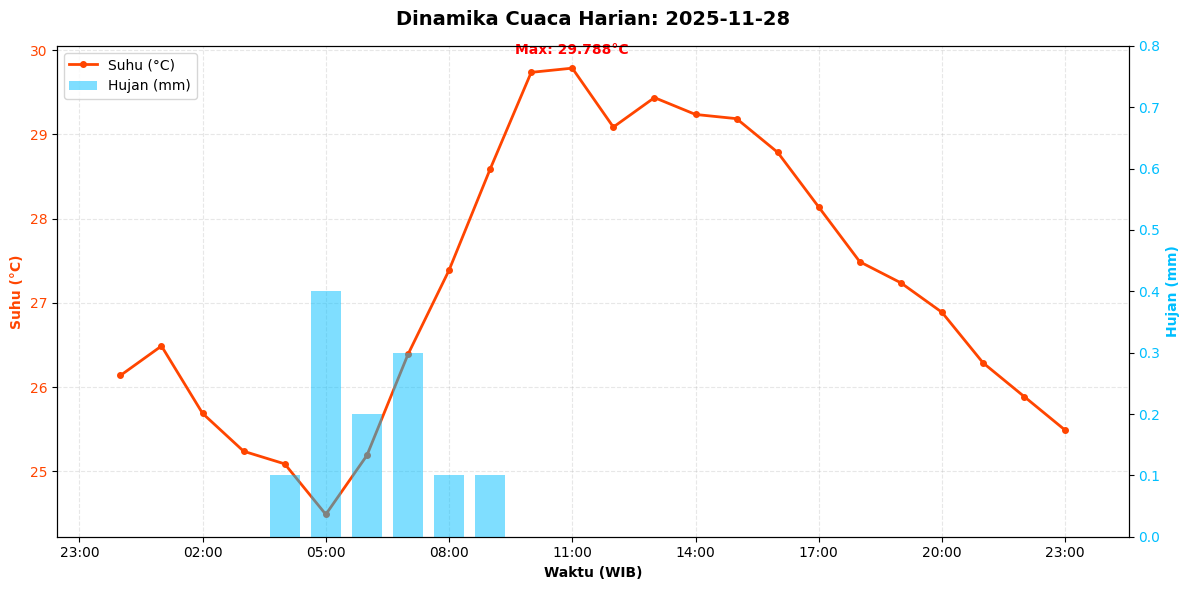

In [10]:
# =========================================================
# CONTOH PENGGUNAAN (MAIN)
# =========================================================
if __name__ == "__main__":
    # Ganti path sesuai file kamu
    PATH_FILE = "/work/open_meteo_climate/kebumen_75tahun_lengkap.csv" 
    
    df_cuaca = load_data(PATH_FILE)
    
    if df_cuaca is not None:
        # Contoh 1: Analisis Ringkas (Teks)
        TANGGAL_TARGET = "2025-11-28" # Tanggal Hujan Lebat
        analisis_detail(df_cuaca, TANGGAL_TARGET)
        
        # Contoh 2: Plot Grafik Detail Hari Tersebut
        plot_harian_detail(df_cuaca, TANGGAL_TARGET)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=672c3bf7-b636-46e8-b7c0-4f6feec29313' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>